In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateauCallback
from tqdm.notebook import tqdm as tqdm
import json

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']
    IMAGE_DIR = path_dict['small_faces']
print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df = df[df['split']=='1st_level']
df = df[df['first_person_label']>-1]
df = df[df['cv_fold']<5]
df['isValFold'] = df['cv_fold'] == 4
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version,isValFold
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17,False
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17,False
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17,False
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",NaN,ptpwappdyx.mp4,2020-02-17,False
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17,False


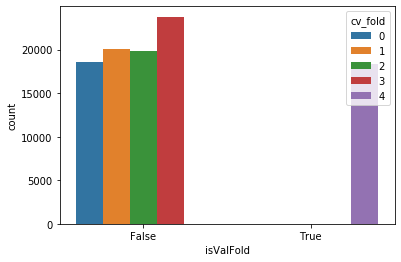

In [3]:
sns.countplot(x='isValFold',hue='cv_fold',data=df)

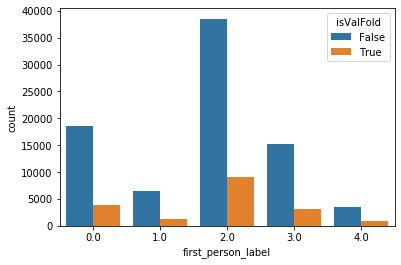

In [4]:
sns.countplot(x='first_person_label',hue='isValFold',data=df)

Get sampled real-fake face pairs.

In [5]:
from util.ImageSampling import getBalancedImageDataFrame

#sampled_df = getBalancedImageDataFrame(IMAGE_DIR,df)

In [6]:
# in case we have to restart this notebook

#sampled_df.to_csv('../tmp/sampled_df.csv',index=False)
sampled_df = pd.read_csv('../tmp/sampled_df.csv')

In [7]:
sampled_df.tail()

,path,label,isValFold
432649,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...,2,False
432650,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...,0,False
432651,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...,1,False
432652,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...,0,False
432653,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...,2,False


In [8]:
# remove directory path from path
sampled_df['path'] = [pth.replace(IMAGE_DIR + '/','') for pth in sampled_df['path'].values]
sampled_df.head()

,path,label,isValFold
0,kqedczfnqm_0_11.png,0,False
1,iniyhknsde_0_11.png,2,False
2,syjiswtrvr_0_10.png,0,True
3,wflzjovedm_0_10.png,3,True
4,hymwuaomiw_0_0.png,0,False


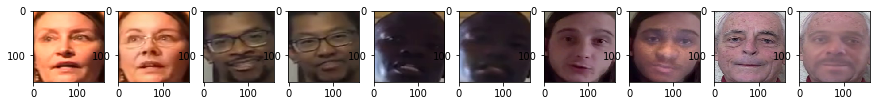

In [9]:
# test that the samples are paired and in order
offset=1048
n_samples = 10

f,ax=plt.subplots(1,n_samples,figsize=(15,15*n_samples))
for i in range(n_samples):
    img_path = os.path.join(IMAGE_DIR,sampled_df.iloc[i+offset]['path'])
    ax[i].imshow(cv2.cvtColor(cv2.imread(str(img_path)),cv2.COLOR_BGR2RGB))

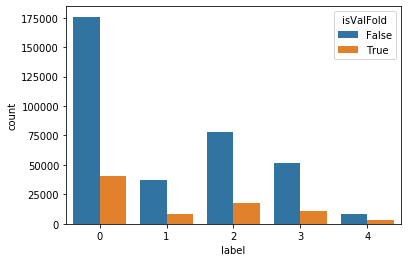

In [10]:
sns.countplot(x='label',hue='isValFold',data=sampled_df)

Change multiclass label back to real/fake binary classes.

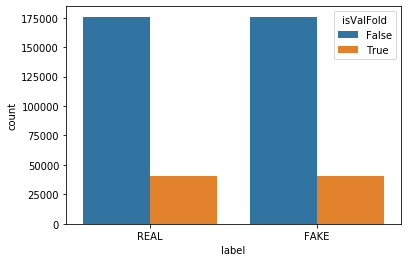

In [11]:
sampled_df['label'] = np.where(sampled_df['label'] > 0, 'FAKE', 'REAL')
sns.countplot(x='label',hue='isValFold',data=sampled_df)

In [12]:
sampled_df['full_path'] = [str(os.path.join(IMAGE_DIR,pth)) for pth in sampled_df['path'].values]
sampled_df.head()

,path,label,isValFold,full_path
0,kqedczfnqm_0_11.png,REAL,False,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...
1,iniyhknsde_0_11.png,FAKE,False,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...
2,syjiswtrvr_0_10.png,REAL,True,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...
3,wflzjovedm_0_10.png,FAKE,True,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...
4,hymwuaomiw_0_0.png,REAL,False,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_fa...


# Train

In [12]:
data = (ImageImageList.from_df(path=IMAGE_DIR, df=sampled_df, cols='path')
        .split_from_df('isValFold')
       .label_from_df('full_path')
       .transform([])
       .databunch(bs=16)
       .normalize(stats=imagenet_stats))

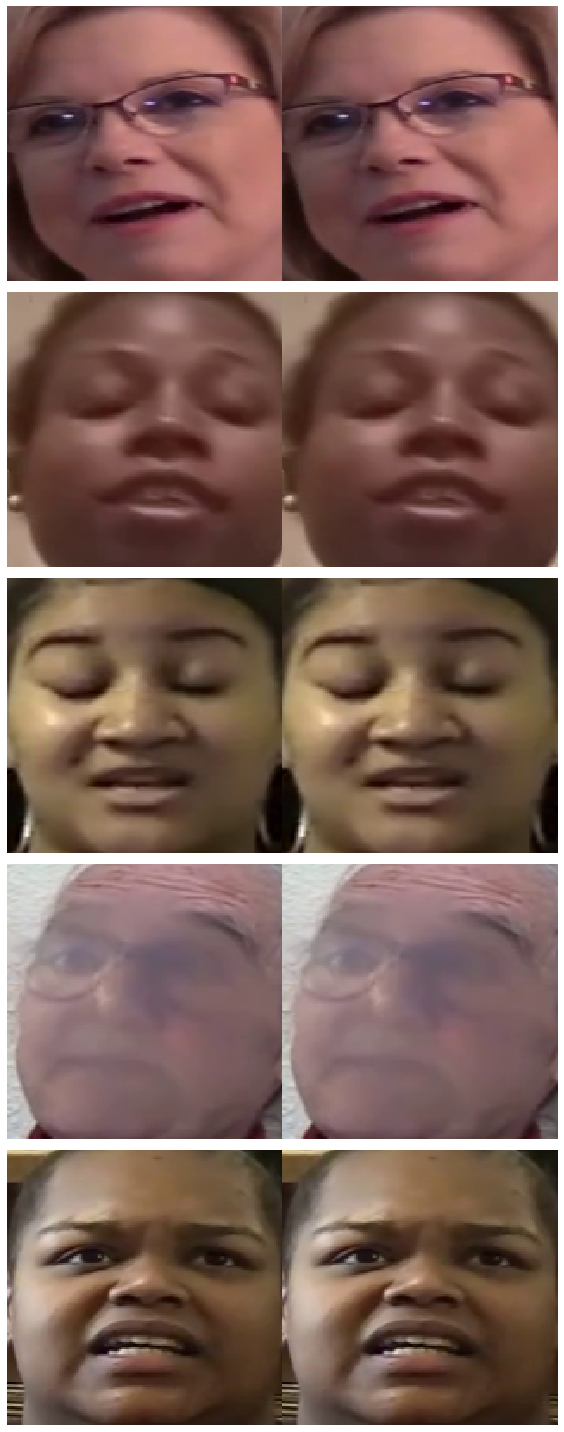

In [13]:
data.show_batch()

In [14]:
import sys
sys.path.append('../detector/')
from Autoencoder.AutoencoderModel import *

In [17]:
model = SimpleAEModel()

In [19]:
learn = Learner(data,model,loss_func=F.mse_loss)
learn.split(lambda m: (m[4],m[5]))

Learner(data=ImageDataBunch;

Train: LabelList (351684 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_faces_2;

Valid: LabelList (80970 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/small_faces_2;

Test: None, model=Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SwishJit()
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 3

In [20]:
learn.freeze_to(1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


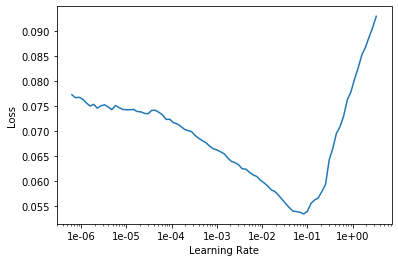

In [21]:
learn.lr_find()
learn.recorder.plot()

## Train head only

Start with one-cycle.

In [22]:
learn.fit_one_cycle(1,2e-3)

epoch,train_loss,valid_loss,time
0,0.002644,0.002782,25:57


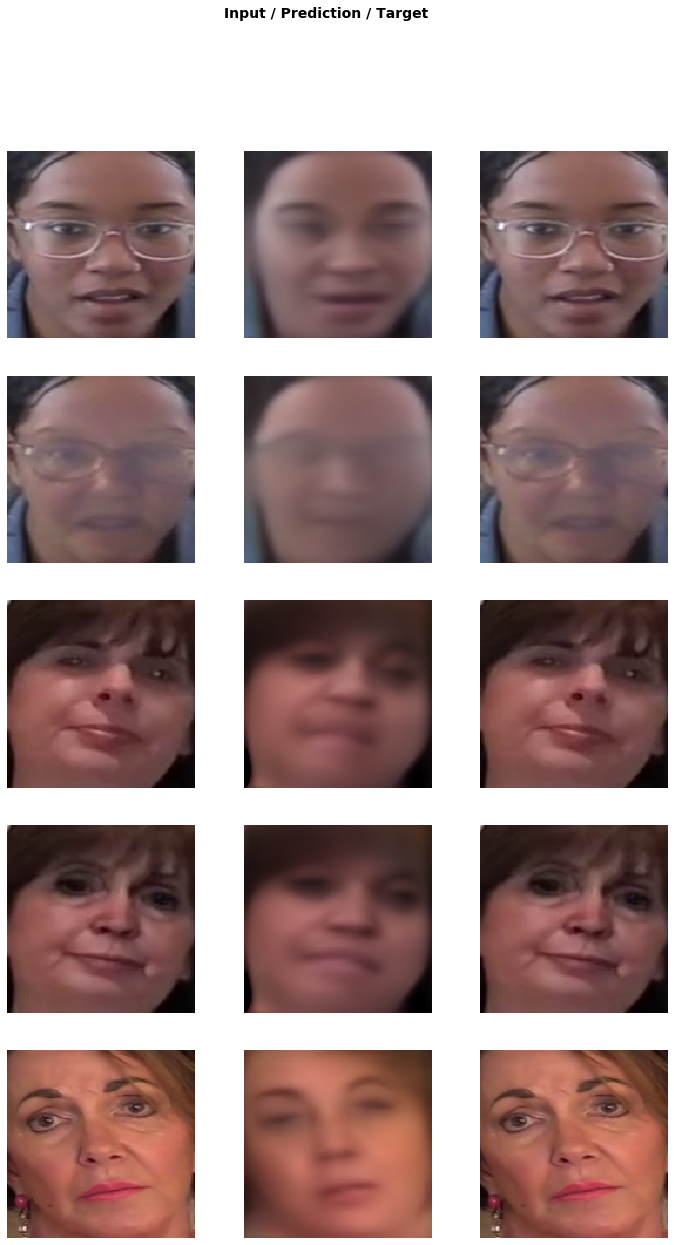

In [23]:
learn.show_results()

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(2,5e-4)

epoch,train_loss,valid_loss,time
0,0.001763,0.001796,34:50
1,0.001348,0.001501,36:03


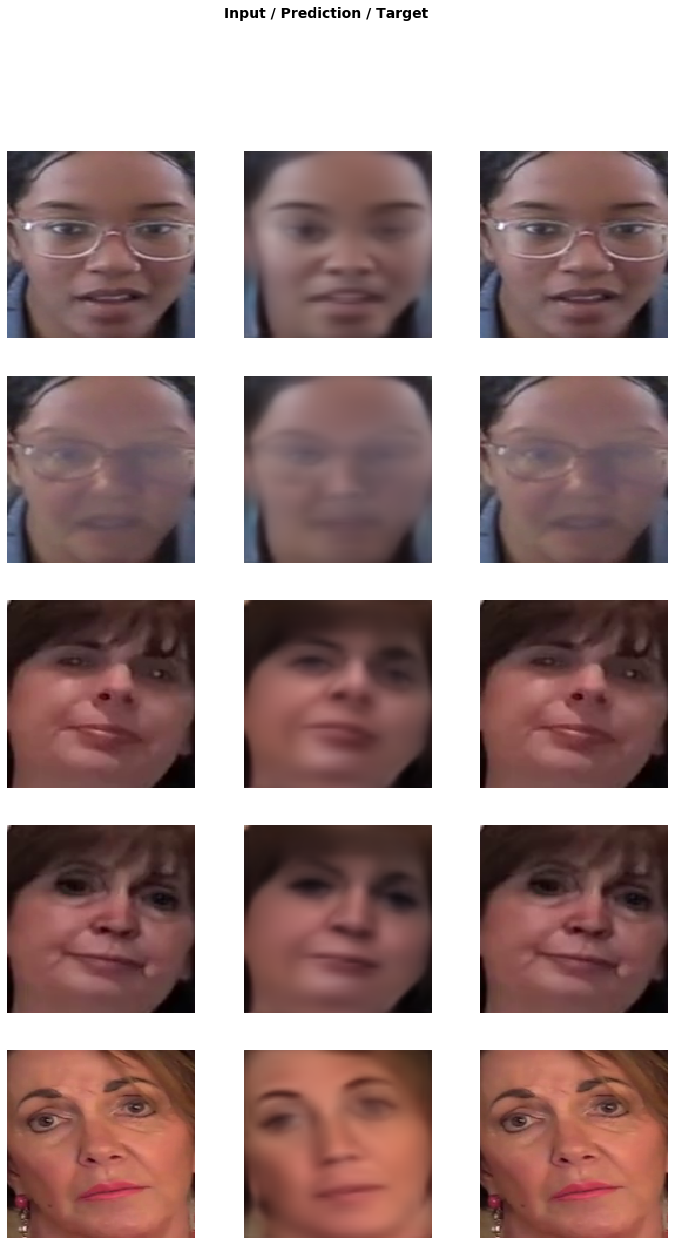

In [26]:
learn.show_results()

# Export the model

In [28]:
if not os.path.exists('../models/autoencoder'):
    os.mkdir('../models/autoencoder')
os.mkdir('../models/autoencoder/2020_03_18-f4')

In [29]:
learn.export(file="/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/autoencoder/2020_03_18-f4/export.pkl")

# Evaluation

In [15]:
learn = load_learner("/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/autoencoder/2020_03_18-f4/")

Test with two person cases that might have more failed face detections. 

In [41]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df = df[df['split']=='1st_level']
df = df[df['first_person_label']>-1]
df = df[df['second_person_label']>-1]
df = df[df['cv_fold']<5]
df['isValFold'] = df['cv_fold'] == 4

In [42]:
from util.ImageSampling import getAllImagesDataFrame

sampled_df = getAllImagesDataFrame(IMAGE_DIR,df)

In [48]:
sampled_df['path'] = [pth.replace(IMAGE_DIR + '/','') for pth in sampled_df['path'].values]
sampled_df['full_path'] = [str(os.path.join(IMAGE_DIR,pth)) for pth in sampled_df['path'].values]

In [67]:
# smaller set for validation
sub_df = sampled_df[:50000]
data = (ImageImageList.from_df(path=IMAGE_DIR, df=sub_df, cols='path')
        #.split_from_df('isValFold')
        .split_by_rand_pct(0.5)
        .label_from_df('full_path')
        .transform([])
       .databunch(bs=16)
       .normalize(stats=imagenet_stats))

In [68]:
learn.data = data

In [69]:
val_preds, ys, losses = learn.get_preds(with_loss=True)

In [70]:
highest_losses = torch.argsort(torch.sum(losses,(1,2,3)), descending=True)
lowest_losses = torch.argsort(torch.sum(losses,(1,2,3)), descending=False)

## Highest losses

tensor(424.9360)


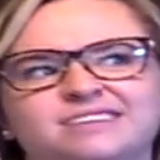

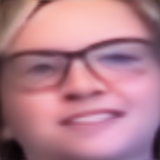

tensor(407.2299)


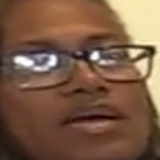

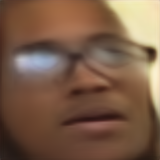

tensor(403.2837)


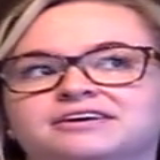

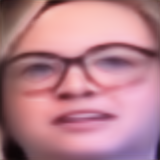

tensor(400.9709)


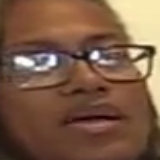

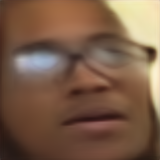

tensor(399.0892)


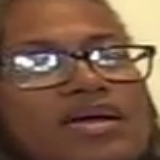

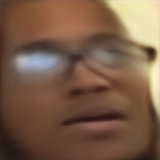

In [71]:
from IPython.display import display
plot_n = 5
for i in range(plot_n):
    ind = highest_losses[i]
    print(torch.sum(losses,(1,2,3))[ind])
    display(Image(ys[ind]))
    display(Image(val_preds[ind]))

## Lowest losses

tensor(9.1601)


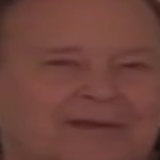

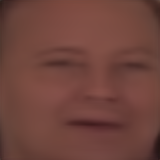

tensor(9.1785)


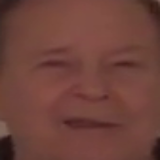

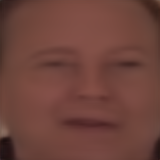

tensor(9.5560)


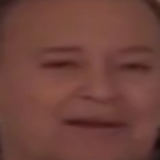

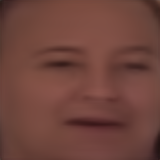

tensor(9.6112)


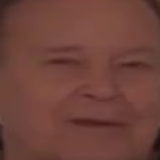

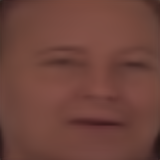

tensor(9.6298)


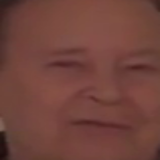

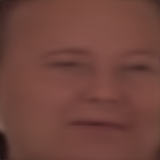

In [72]:
plot_n = 5
for i in range(plot_n):
    ind = lowest_losses[i]
    print(torch.sum(losses,(1,2,3))[ind])
    display(Image(ys[ind]))
    display(Image(val_preds[ind]))